In [1]:
import pandas as pd
import numpy as np
import cupy as cp  # CuPy for GPU arrays (optional)
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.plotting


In [2]:
def plot_parity_with_metrics(target_name, data, metrics, save_path=None):
    """
    Creates a parity (observed vs. predicted) plot for train and test sets,
    annotated with MSE and R² metrics.
    """
    observed_train  = data["train_observed"]
    predicted_train = data["train_predicted"]
    observed_test   = data["test_observed"]
    predicted_test  = data["test_predicted"]

    train_mse = metrics["train_mse"]
    test_mse  = metrics["test_mse"]
    test_r2   = metrics["test_r2"]

    plt.figure(figsize=(8, 6))
    plt.scatter(observed_train, predicted_train, label="Train", color="blue", alpha=0.6)
    plt.scatter(observed_test, predicted_test, label="Test", color="red", alpha=0.6)

    # Plot perfect-fit line
    min_val = min(observed_train.min(), observed_test.min())
    max_val = max(observed_train.max(), observed_test.max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="black", label="Perfect Fit")

    # Text box with metrics
    metrics_text = (
        f"Train MSE: {train_mse:.2f}\n"
        f"Test MSE:  {test_mse:.2f}\n"
        f"Test R²:   {test_r2:.2f}"
    )
    plt.text(
        0.05, 0.95, metrics_text,
        transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
    )

    plt.xlabel(f"Observed {target_name}")
    plt.ylabel(f"Predicted {target_name}")
    plt.title(f"Parity Plot for {target_name}")
    plt.legend()
    plt.grid(True)

    if save_path:
        plt.savefig(save_path, dpi=1200, bbox_inches="tight")
    plt.close()

In [3]:
polystyrene_path = r"C:\Users\Dillo\OneDrive\Documents\GitHub\LCCC-ML\polystyrene-imputated-solvents-hot-encoded-2-23-25.xlsx"
polystyrene = pd.read_excel(polystyrene_path)

In [4]:
# Our 20 target columns (one for each solvent ratio)
solvent_cols = [
    'Hexane', 'Tetrahydrofuran', 'Dichloromethane', 'Acetonitrile',
    'Tetrachloromethane', 'Ethyl Acetate', 'Toluene', 'Carbon Dioxide',
    'Xylene', 'Cyclohexane', 'Dimethylacetamide', 'Heptane', 'Decalin',
    'Dimethylformamide', 'Water', 'Chloroform', 'Methanol',
    '2,2,4-Trimethylpentane', 'Methyl Ethyl Ketone', 'Cyclohexanone'
]

In [5]:
# Solvent ratios become our multi-column "target," but we will treat them
# individually by training one XGBRegressor per column.
y = polystyrene[solvent_cols].values  # shape: (n_samples, 20)

In [6]:
# Feature columns (exclude polymer name and the 20 solvents)
columns_to_drop = ["Polymer"] + solvent_cols
feature_columns = polystyrene.drop(columns=columns_to_drop).columns
X = polystyrene.drop(columns=columns_to_drop).values  # shape: (n_samples, n_features)

In [7]:
print("Feature matrix X shape:", X.shape)
print("Target y shape:", y.shape)

Feature matrix X shape: (172, 173)
Target y shape: (172, 20)


In [8]:
# For final usage, we have:
# - 80% "train"
# - 10% "val" (for early stopping)
# - 10% "test"

X_train_np, X_temp_np, y_train_np, y_temp_np, idx_train, idx_temp = train_test_split(
    X, y, np.arange(len(X)), test_size=0.20, random_state=42
)
X_val_np, X_test_np, y_val_np, y_test_np, idx_val, idx_test = train_test_split(
    X_temp_np, y_temp_np, idx_temp, test_size=0.5, random_state=42
)

In [9]:
print(f"Train size:      {X_train_np.shape[0]}")
print(f"Validation size: {X_val_np.shape[0]}")
print(f"Test size:       {X_test_np.shape[0]}")

Train size:      137
Validation size: 17
Test size:       18


In [10]:
# convert to GPU arrays (CuPy) for the final training
X_train_cp = cp.asarray(X_train_np)
y_train_cp = cp.asarray(y_train_np)
X_val_cp   = cp.asarray(X_val_np)
y_val_cp   = cp.asarray(y_val_np)
X_test_cp  = cp.asarray(X_test_np)
y_test_cp  = cp.asarray(y_test_np)

In [11]:
def train_single_output_with_early_stopping(
    X_tr_fold, y_tr_fold, 
    X_val_fold, y_val_fold, 
    params
):
    """
    Train a SINGLE xgboost model for a single solvent column
    using early stopping on (X_val_fold, y_val_fold).
    Return the MSE on that fold's val set.
    """
    model = xgb.XGBRegressor(
        **params,
        objective='reg:squarederror',
        early_stopping_rounds=10,
        verbosity = 1
    )
    model.fit(
        X_tr_fold, y_tr_fold,
        eval_set=[(X_val_fold, y_val_fold)],
        verbose=False  # set True if you want to see early-stopping progress
    )
    y_pred = model.predict(X_val_fold)
    mse    = mean_squared_error(y_val_fold, y_pred)
    return mse


def objective(params):
    # Convert search-space floats to int/float as needed
    params['n_estimators']      = int(params['n_estimators'])
    params['max_depth']         = int(params['max_depth'])
    params['learning_rate']     = float(params['learning_rate'])
    params['gamma']             = float(params['gamma'])
    params['min_child_weight']  = int(params['min_child_weight'])
    params['subsample']         = float(params['subsample'])
    params['colsample_bytree']  = float(params['colsample_bytree'])
    params['reg_alpha']         = float(params['reg_alpha'])
    params['reg_lambda']        = float(params['reg_lambda'])
    params['max_bin']           = int(params['max_bin'])
    params['max_cat_threshold'] = int(params['max_cat_threshold'])

    # Force GPU usage in XGBoost
    params['tree_method'] = 'hist'
    params['device']      = 'cuda'
    
    # 5-fold CV on the train set only (CPU arrays).
    # Typically you wouldn't use the "val" set here. It's separate for final check.
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_mses = []
    
    for train_idx, val_idx in kf.split(X_train_np):
        X_tr_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
        y_tr_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]
        
        # We have y_tr_fold.shape = (num_samples_in_fold, 20)
        # We'll train 20 separate single-output models, each with early stopping.
        mses_for_this_fold = []
        for col_i in range(y_tr_fold.shape[1]):
            fold_mse_col = train_single_output_with_early_stopping(
                X_tr_fold, y_tr_fold[:, col_i],
                X_val_fold, y_val_fold[:, col_i],
                params
            )
            mses_for_this_fold.append(fold_mse_col)
        
        # Average MSE across the 20 columns for this fold
        fold_mean_mse = np.mean(mses_for_this_fold)
        fold_mses.append(fold_mean_mse)
    
    # Average MSE across the 5 folds
    avg_mse = np.mean(fold_mses)
    return {'loss': avg_mse, 'status': STATUS_OK}

In [12]:
search_space = {
    'n_estimators':       hp.quniform('n_estimators', 50, 500, 10),
    'max_depth':          hp.quniform('max_depth', 3, 5, 1),
    'learning_rate':      hp.loguniform('learning_rate', -4, -1),
    'subsample':          hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree':   hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha':          hp.loguniform('reg_alpha', -5, 2),
    'reg_lambda':         hp.loguniform('reg_lambda', -5, 2),
    'gamma':              hp.uniform('gamma', 0, 7),
    'min_child_weight':   hp.quniform('min_child_weight', 1, 5, 1),
    'max_bin':            hp.quniform('max_bin', 128, 1024, 16),
    'max_cat_threshold':  hp.quniform('max_cat_threshold', 16, 1024, 16)
}

trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=300,  # Increase if you want a bigger hyperparam search
    trials=trials
)


  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

c:\Users\Dillo\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



100%|██████████| 300/300 [53:31<00:00, 10.70s/trial, best loss: 15.923595803754168] 


In [13]:
# Convert best_params from hyperopt
best_params['n_estimators']      = int(best_params['n_estimators'])
best_params['max_depth']         = int(best_params['max_depth'])
best_params['learning_rate']     = float(best_params['learning_rate'])
best_params['gamma']             = float(best_params['gamma'])
best_params['min_child_weight']  = int(best_params['min_child_weight'])
best_params['subsample']         = float(best_params['subsample'])
best_params['colsample_bytree']  = float(best_params['colsample_bytree'])
best_params['reg_alpha']         = float(best_params['reg_alpha'])
best_params['reg_lambda']        = float(best_params['reg_lambda'])
best_params['max_bin']           = int(best_params['max_bin'])
best_params['max_cat_threshold'] = int(best_params['max_cat_threshold'])
best_params['tree_method']       = 'hist'
best_params['device']            = 'cuda'
best_params['objective']         = 'reg:squarederror'
# early_stopping_rounds is used in the .fit() calls

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'colsample_bytree': 0.5110708618671079, 'gamma': 0.31194571707985774, 'learning_rate': 0.19217912298179865, 'max_bin': 512, 'max_cat_threshold': 912, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 480, 'reg_alpha': 0.39341541487275117, 'reg_lambda': 5.9402624700077205, 'subsample': 0.9702025835866855, 'tree_method': 'hist', 'device': 'cuda', 'objective': 'reg:squarederror'}


In [16]:
# Train Final Single‐Output Models on (Train=80%) + (Val=10%) for Early Stopping
# -----------------------------------------------------------------------------
# In many workflows, you'd combine the train+val for final training. But since
# you specifically want the val set for early stopping, let's do:
#
#   final_model[col_i].fit(X_train, y_train[:, col_i],
#                          eval_set=[(X_val, y_val[:, col_i])],
#                          early_stopping_rounds=10)
#
# We do that for each column. Then we evaluate on test.

final_models = []
for col_i in range(y_train_np.shape[1]):
    model_i = xgb.XGBRegressor(**best_params)
    # Train on GPU arrays with early stopping on GPU arrays
    model_i.fit(
        X_train_cp, y_train_cp[:, col_i],
        eval_set=[(X_val_cp, y_val_cp[:, col_i])],
        
        verbose=True
    )
    final_models.append(model_i)


[0]	validation_0-rmse:20.18521
[1]	validation_0-rmse:16.78684
[2]	validation_0-rmse:13.96162
[3]	validation_0-rmse:11.65926
[4]	validation_0-rmse:9.98850
[5]	validation_0-rmse:8.52249
[6]	validation_0-rmse:7.37669
[7]	validation_0-rmse:6.72111
[8]	validation_0-rmse:6.08424
[9]	validation_0-rmse:5.84134
[10]	validation_0-rmse:5.51761
[11]	validation_0-rmse:5.54252
[12]	validation_0-rmse:5.57488
[13]	validation_0-rmse:5.34240
[14]	validation_0-rmse:5.41025
[15]	validation_0-rmse:5.24505
[16]	validation_0-rmse:5.21383
[17]	validation_0-rmse:5.17870
[18]	validation_0-rmse:5.11564
[19]	validation_0-rmse:5.11393
[20]	validation_0-rmse:5.13855
[21]	validation_0-rmse:5.12039
[22]	validation_0-rmse:5.11162
[23]	validation_0-rmse:5.13769
[24]	validation_0-rmse:5.09464
[25]	validation_0-rmse:5.09087
[26]	validation_0-rmse:5.06690
[27]	validation_0-rmse:5.06466
[28]	validation_0-rmse:5.07440
[29]	validation_0-rmse:5.13319
[30]	validation_0-rmse:5.12276
[31]	validation_0-rmse:5.11039
[32]	validatio

In [17]:
# Evaluate on Test Set (10%)
# -----------------------------------------------------------------------------
# We'll compute the average MSE and R² across all 20 columns

test_mses = []
test_r2s  = []

for col_i, model_i in enumerate(final_models):
    y_pred_col_cp = model_i.predict(X_test_cp)
    y_pred_col_np = cp.asnumpy(y_pred_col_cp)
    
    y_true_col_np = y_test_np[:, col_i]
    
    mse_col = mean_squared_error(y_true_col_np, y_pred_col_np)
    r2_col  = r2_score(y_true_col_np, y_pred_col_np)
    
    test_mses.append(mse_col)
    test_r2s.append(r2_col)

avg_test_mse = np.mean(test_mses)
avg_test_r2  = np.mean(test_r2s)

print(f"Final Test MSE (averaged across 20 solvents): {avg_test_mse:.4f}")
print(f"Final Test R²  (averaged across 20 solvents): {avg_test_r2:.4f}")

Final Test MSE (averaged across 20 solvents): 129.6524
Final Test R²  (averaged across 20 solvents): -1.5053



Average Feature Importances (across all 20 single‐output models):
                      feature  importance
16                       Chi0    0.053963
101               VSA_EState8    0.043855
38                 ExactMolWt    0.042404
48                    MolLogP    0.031493
54   NumAliphaticHeterocycles    0.030602
119                fr_nitrile    0.029939
22                      Chi4v    0.026906
14                   BalabanJ    0.026619
75                 PEOE_VSA14    0.025929
86                 SlogP_VSA2    0.024874
19                      Chi1v    0.022571
68                  PEOE_VSA5    0.022214
24                      Chi1n    0.021625
36                EState_VSA9    0.021094
88                 SlogP_VSA4    0.018818
45                     Kappa2    0.017203
31                EState_VSA4    0.016715
71                  PEOE_VSA8    0.016712
114                  fr_ester    0.016537
20                      Chi2v    0.015685


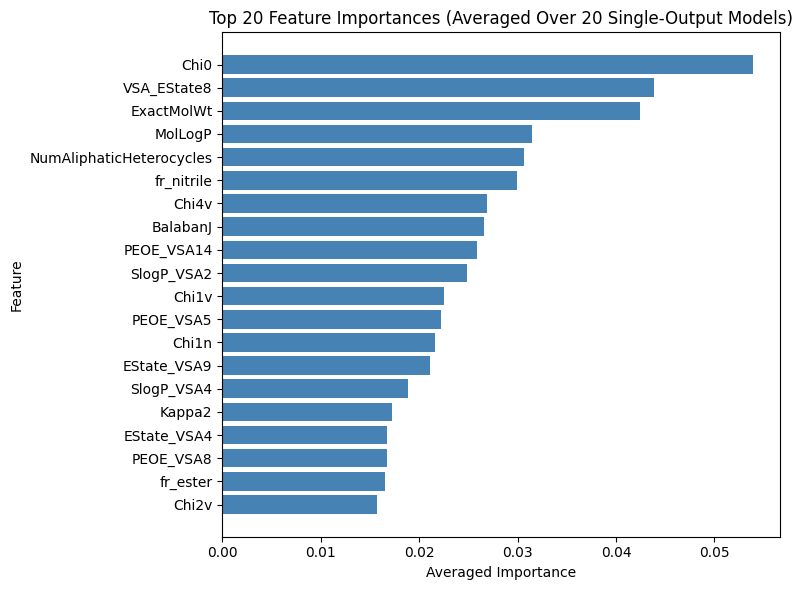

In [18]:
# 7) Feature Importances
# -----------------------------------------------------------------------------
# Each single‐output model has its own feature_importances_.
# You can inspect or average them. For example:

importances_list = []
for col_i, model_i in enumerate(final_models):
    fi = model_i.feature_importances_
    importances_list.append(fi)

mean_importances = np.mean(importances_list, axis=0)

feature_importance_df = pd.DataFrame({
    "feature": feature_columns,
    "importance": mean_importances
}).sort_values("importance", ascending=False)

print("\nAverage Feature Importances (across all 20 single‐output models):")
print(feature_importance_df.head(20))

# bar plot of top 20 averaged importances
top_n = 20
top_feats = feature_importance_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_feats["feature"], top_feats["importance"], color="steelblue")
plt.xlabel("Averaged Importance")
plt.ylabel("Feature")
plt.title(f"Top {top_n} Feature Importances (Averaged Over 20 Single‐Output Models)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

avg best error: 15.923595803754168


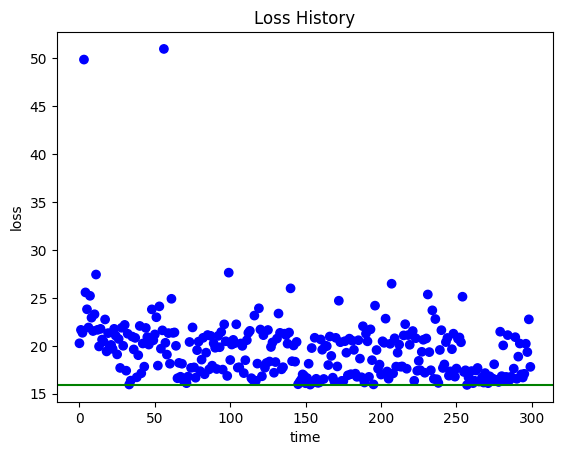

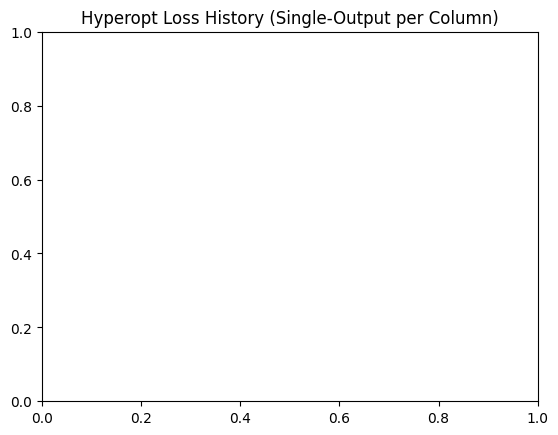

Showing Histogram of 300 jobs


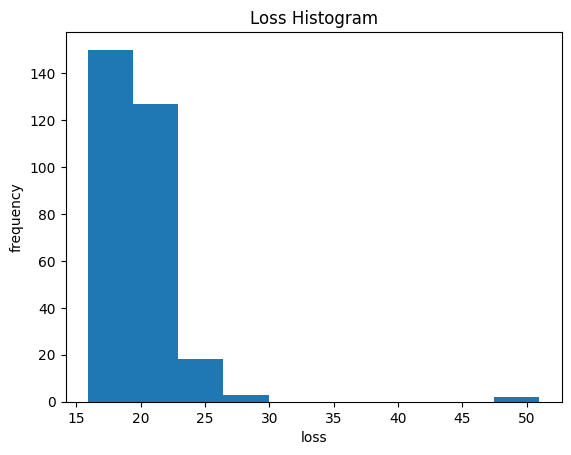

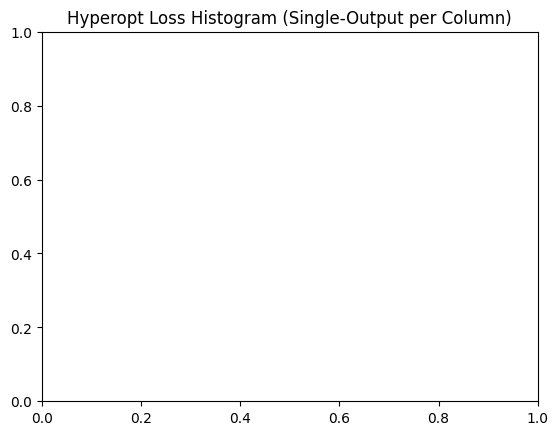

finite loss range 15.923595803754168 50.97195455137842 14.923595803754168


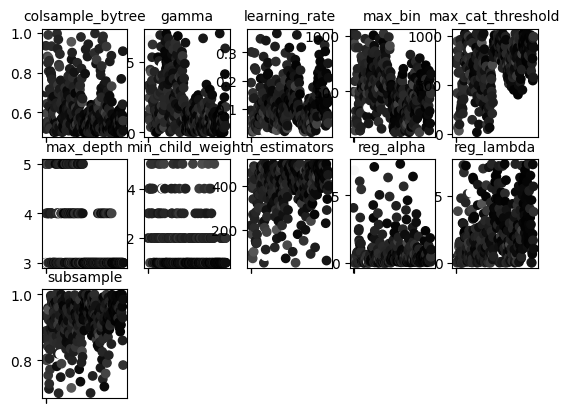

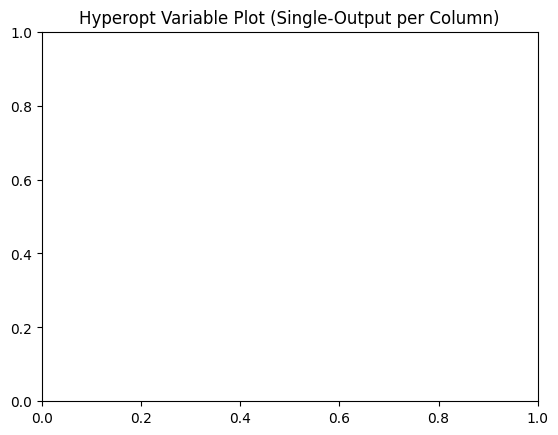

In [19]:
# Hyperopt Plots (optional)
# -----------------------------------------------------------------------------
hyperopt.plotting.main_plot_history(trials)
plt.title("Hyperopt Loss History (Single‐Output per Column)")
plt.show()

hyperopt.plotting.main_plot_histogram(trials)
plt.title("Hyperopt Loss Histogram (Single‐Output per Column)")
plt.show()

hyperopt.plotting.main_plot_vars(trials)
plt.title("Hyperopt Variable Plot (Single‐Output per Column)")
plt.show()